Given
$ \displaystyle
    \frac{d^2 y}{d x^2} - \frac{c_1 y}{c_2 + y} = 0
$
find $y$

$ \displaystyle
\mathcal{L} = \int_{C} \left| \frac{d^2 y}{d x^2} - \frac{c_1 y}{c_2 + y} \right| \; dC
$

$ \displaystyle
\mathcal{L} = \int_{C} \left( \frac{d^2 y}{d x^2} - \frac{c_1 y}{c_2 + y} \right)^2 \; dC
$


$C$ – $c_1$, $c_2$ space


\begin{cases}
    c_1 = \sigma^2 \quad \text{(normalizuotas)}\\
    c_2 = 1
\end{cases}



# DARTS

$ \displaystyle
\overline{o}^{(i, j)}(x) = \sum_{o \in \mathcal{O}} \left( \alpha_o^{(i,j)} o(x) \right)
\\ \displaystyle
\forall (i, j) \; R = (\sum_{o \in \mathcal{O}} \alpha_o^{(i, j)} - 1)^2
$

# Code

In [1]:
import sympy as sp
from jax import random
import jax.numpy as np

# !rm /etc/localtime
# !ln -s /usr/share/zoneinfo/Europe/Vilnius /etc/localtime

from util.plot import Plotting
from util.print import a, d, pad, info
from network import Network
from train import train

In [2]:
def actual_func(z, c_1, c_2=1, c_3=0):
    return c_1 * z - c_2 * c_1 * np.log(c_2 + z) + c_3

In [3]:
c1 = sp.symbols('c_1')
x_bounds = (0, 4)
c1_bounds = (1.4, 1.6)

In [4]:
loss_model_func = lambda model_y, x: sp.Pow(sp.diff(model_y, x, 2) - c1 * (model_y) / (1 + model_y), 2, evaluate=False)
loss_integration_func = lambda loss_model: (loss_model, (c1, *c1_bounds))

In [5]:
cell_count = 3
network = Network(
  loss_model_func,
  loss_integration_func,
  [
    lambda z: 0,
    lambda z: 1,
    lambda z: -1,
    lambda z: z,
    # lambda z: -z,
    lambda z: z*z,
    lambda z: z*z*z*z,
    # lambda z: z*z,
    # lambda x: sp.sin(x),
    # lambda z: sp.exp(z),
    # lambda x: sp.Max(x, 0)
    # lambda x: 1 / (1 + sp.exp(-x))
], cell_count, x_bounds)

16:40:59.239 [INFO] Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
16:40:59.240 [INFO] Unable to initialize backend 'gpu': NOT_FOUND: Could not find registered platform with name: "cuda". Available platform names are: Interpreter Host
16:40:59.241 [INFO] Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.


In [6]:
_, model_y, _, _ = network.get_model(should_integrate=False)
# _, model_y, loss_and_grad, _ = network.get_model(should_integrate=True)

16:40:59.517 [INFO] Constructed symbolic model


In [7]:
model_y

a_o1__00__02 + a_o1__01__02 - a_o2__00__02 - a_o2__01__02 + a_o3__00__02*x + a_o3__01__02*(a_o1__00__01 - a_o2__00__01 + a_o3__00__01*x + a_o4__00__01*x**2 + a_o5__00__01*x**4) + a_o4__00__02*x**2 + a_o4__01__02*(a_o1__00__01 - a_o2__00__01 + a_o3__00__01*x + a_o4__00__01*x**2 + a_o5__00__01*x**4)**2 + a_o5__00__02*x**4 + a_o5__01__02*(a_o1__00__01 - a_o2__00__01 + a_o3__00__01*x + a_o4__00__01*x**2 + a_o5__00__01*x**4)**4 + b

In [8]:
# loss_model_func(model_y, network.x)

In [9]:
model_y_numeric = model_y.subs(list(zip(network.alphas, [0.01]*19)))
model_y_numeric

0.0101*x**4 + 0.0101*x**2 + 0.0101*x + 1.0e-10*(x**4 + x**2 + x)**4 + 1.0e-6*(x**4 + x**2 + x)**2 + 0.01

In [10]:
loss_model_func(model_y_numeric, network.x)

(-c_1*(0.0101*x**4 + 0.0101*x**2 + 0.0101*x + 1.0e-10*(x**4 + x**2 + x)**4 + 1.0e-6*(x**4 + x**2 + x)**2 + 0.01)/(0.0101*x**4 + 0.0101*x**2 + 0.0101*x + 1.0e-10*(x**4 + x**2 + x)**4 + 1.0e-6*(x**4 + x**2 + x)**2 + 1.01) + 8.0e-10*x**3*(6*x**2 + 1)*(x**3 + x + 1)**3 + 1.2e-9*x**2*(x**3 + x + 1)**2*(4*x**3 + 2*x + 1)**2 + 0.1212*x**2 + x*(2.4e-5*x**2 + 4.0e-6)*(x**3 + x + 1) + (8.0e-6*x**3 + 4.0e-6*x + 2.0e-6)*(4*x**3 + 2*x + 1) + 0.0202)**2

In [11]:
loss_model = loss_model_func(model_y_numeric, network.x)
loss_integrated = sp.integrate(*loss_integration_func(loss_model))
loss_integrated += network.penalties

In [12]:
loss_func = network.lambdify2(model_y_numeric)

In [13]:
loss_func(np.array([0.5, 0.1]))

(DeviceArray([0.01820691, 0.01111202], dtype=float32),
 DeviceArray([0.02525406, 0.01216066], dtype=float32))

In [6]:
# network.debug['loss_integrated']

In [7]:
# pabandyti įsistačius numerically, su visais a_*, b, x

In [8]:
plotting = Plotting(actual_func, network, x_bounds, c1_bounds)

23:49:31.915 [INFO] W₀ = [ 0.0692,  0.0652,  0.0406,  0.0854,  0.0093,  0.0399,  0.0650,  0.0526,  0.0854,  0.0454,  0.0774,  0.0397,  0.0585]
23:49:34.270 [INFO] Epoch: 1, Loss: 87.08128356933594,	W = [ 0.1435,  0.1352,  0.1193,  0.1592,  0.0935,  0.0663,  0.2070,  0.1290,  0.1611,  0.0633,  0.2109,  0.1133,  0.0007]



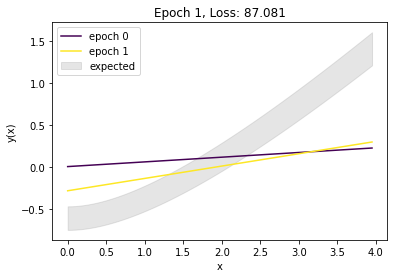

23:49:34.797 [INFO] Epoch: 2, Loss: 32.19112777709961,	W = [ 0.1881,  0.1764,  0.1670,  0.2033,  0.1443,  0.0930,  0.2819,  0.1765,  0.2065,  0.0846,  0.2804,  0.1577, -0.0234]



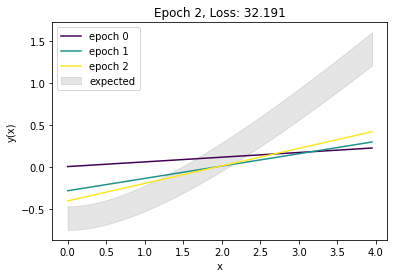

23:49:34.963 [INFO] Epoch: 3, Loss: 14.080619812011719,	W = [ 0.2147,  0.2017,  0.1951,  0.2295,  0.1750,  0.1154,  0.3209,  0.2047,  0.2338,  0.1035,  0.3159,  0.1844, -0.0317]



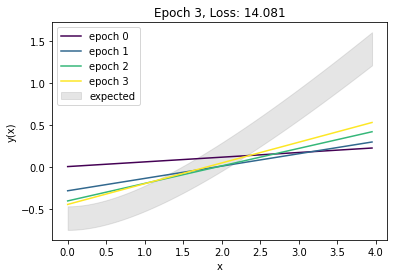

23:49:35.130 [INFO] Epoch: 4, Loss: 7.899202346801758,	W = [ 0.2307,  0.2170,  0.2119,  0.2448,  0.1937,  0.1302,  0.3435,  0.2198,  0.2501,  0.1160,  0.3362,  0.1999, -0.0356]



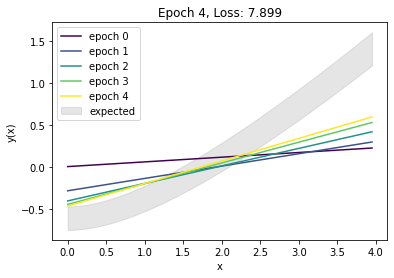

23:49:35.306 [INFO] Epoch: 5, Loss: 5.734958648681641,	W = [ 0.2404,  0.2263,  0.2219,  0.2536,  0.2053,  0.1400,  0.3568,  0.2274,  0.2600,  0.1241,  0.3478,  0.2087, -0.0374]



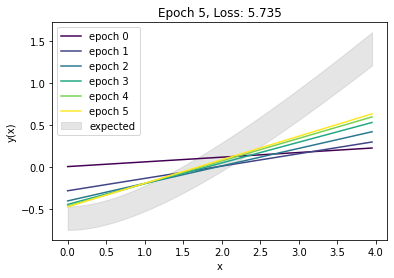

23:49:35.488 [INFO] Epoch: 6, Loss: 4.965499401092529,	W = [ 0.2462,  0.2319,  0.2279,  0.2586,  0.2126,  0.1465,  0.3649,  0.2304,  0.2660,  0.1294,  0.3546,  0.2136, -0.0382]



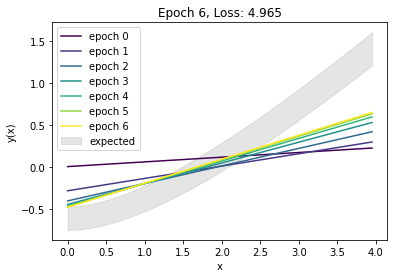

23:49:35.763 [INFO] Epoch: 7, Loss: 4.685845375061035,	W = [ 0.2498,  0.2355,  0.2315,  0.2613,  0.2174,  0.1513,  0.3697,  0.2309,  0.2697,  0.1330,  0.3584,  0.2162, -0.0382]



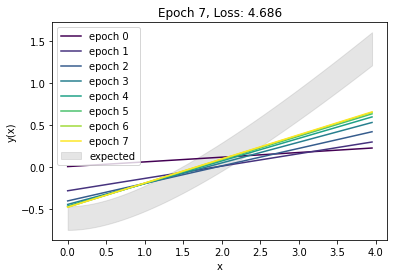

23:49:35.955 [INFO] Epoch: 8, Loss: 4.573573112487793,	W = [ 0.2521,  0.2378,  0.2337,  0.2626,  0.2207,  0.1549,  0.3728,  0.2300,  0.2721,  0.1356,  0.3605,  0.2174, -0.0379]



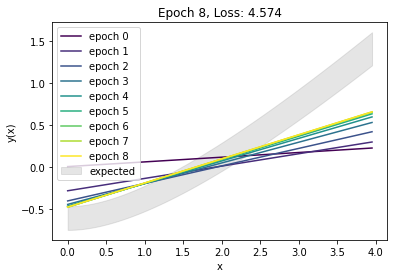

23:49:36.154 [INFO] Epoch: 9, Loss: 4.523473739624023,	W = [ 0.2535,  0.2392,  0.2352,  0.2631,  0.2231,  0.1571,  0.3754,  0.2280,  0.2736,  0.1369,  0.3621,  0.2178, -0.0381]



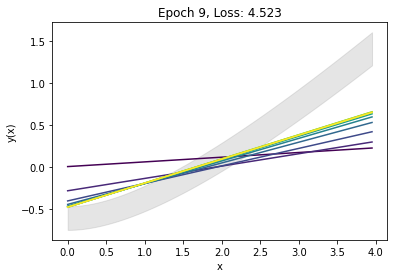

23:49:36.381 [INFO] Epoch: 10, Loss: 4.497699737548828,	W = [ 0.2545,  0.2402,  0.2361,  0.2632,  0.2250,  0.1591,  0.3771,  0.2258,  0.2746,  0.1381,  0.3630,  0.2178, -0.0380]



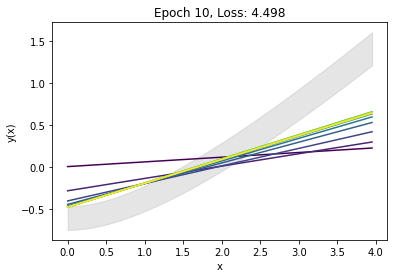

23:49:36.554 [INFO] W = [ 0.2545,  0.2402,  0.2361,  0.2632,  0.2250,  0.1591,  0.3771,  0.2258,  0.2746,  0.1381,  0.3630,  0.2178, -0.0380]
23:49:36.555 [INFO] Pruning weights...
23:49:36.725 [INFO] Constructed symbolic model
23:49:37.440 [INFO] Integrated
23:49:37.870 [INFO] Constructed JAXified model
23:49:37.159 [INFO] W₀ = [ 0.2632,  0.2250,  0.1591,  0.3771,  0.2258,  0.2746,  0.1381,  0.3630,  0.2178, -0.0380]
23:49:37.853 [INFO] Epoch: 1, Loss: 4.477574348449707,	W = [ 0.2623,  0.2265,  0.1607,  0.3786,  0.2234,  0.2753,  0.1389,  0.3637,  0.2174, -0.0379]



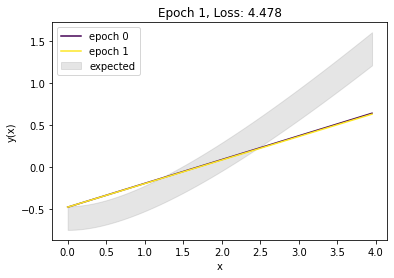

23:49:38.700 [INFO] Epoch: 2, Loss: 4.463254928588867,	W = [ 0.2615,  0.2278,  0.1619,  0.3799,  0.2208,  0.2758,  0.1393,  0.3642,  0.2169, -0.0380]



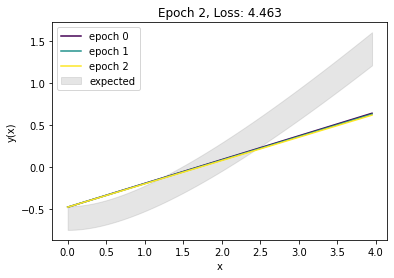

23:49:38.151 [INFO] Epoch: 3, Loss: 4.450232028961182,	W = [ 0.2608,  0.2289,  0.1641,  0.3800,  0.2187,  0.2762,  0.1408,  0.3636,  0.2165, -0.0369]



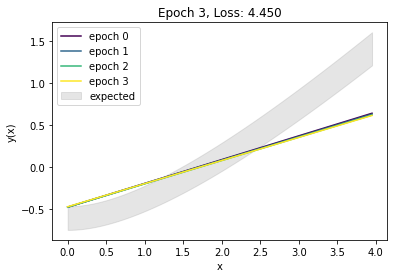

23:49:38.306 [INFO] Epoch: 4, Loss: 4.440944671630859,	W = [ 0.2600,  0.2299,  0.1648,  0.3813,  0.2163,  0.2766,  0.1408,  0.3642,  0.2159, -0.0372]



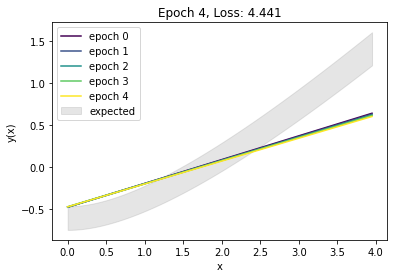

23:49:38.465 [INFO] Epoch: 5, Loss: 4.431433200836182,	W = [ 0.2593,  0.2309,  0.1657,  0.3823,  0.2140,  0.2769,  0.1410,  0.3646,  0.2154, -0.0373]



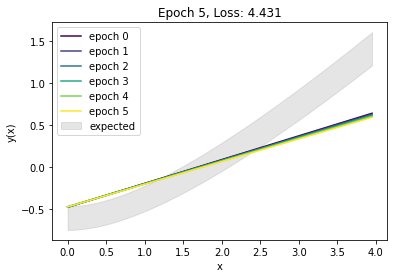

23:49:38.627 [INFO] Epoch: 6, Loss: 4.423661231994629,	W = [ 0.2587,  0.2318,  0.1666,  0.3832,  0.2119,  0.2771,  0.1414,  0.3648,  0.2149, -0.0372]



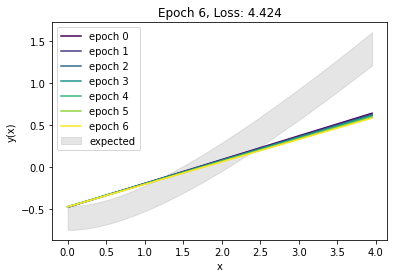

23:49:38.807 [INFO] Epoch: 7, Loss: 4.418333530426025,	W = [ 0.2581,  0.2326,  0.1678,  0.3836,  0.2099,  0.2773,  0.1420,  0.3647,  0.2144, -0.0369]



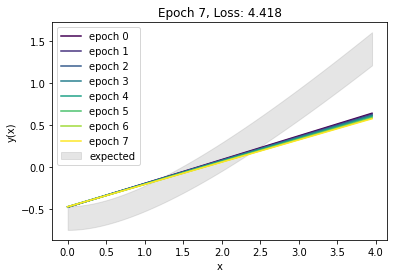

23:49:38.986 [INFO] Epoch: 8, Loss: 4.4101338386535645,	W = [ 0.2575,  0.2333,  0.1690,  0.3839,  0.2082,  0.2775,  0.1426,  0.3644,  0.2139, -0.0364]



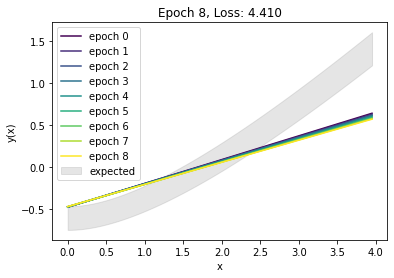

23:49:39.302 [INFO] Epoch: 9, Loss: 4.403825759887695,	W = [ 0.2570,  0.2340,  0.1696,  0.3846,  0.2063,  0.2777,  0.1427,  0.3647,  0.2135, -0.0365]



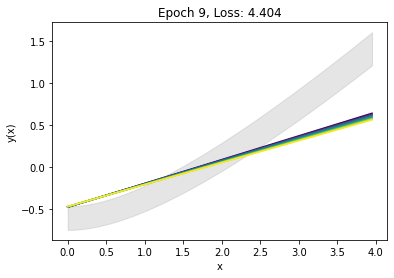

23:49:39.482 [INFO] Epoch: 10, Loss: 4.40024995803833,	W = [ 0.2565,  0.2347,  0.1705,  0.3852,  0.2047,  0.2779,  0.1431,  0.3647,  0.2130, -0.0363]



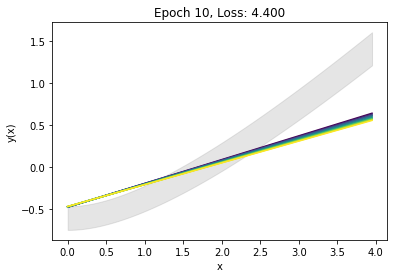

23:49:39.633 [INFO] W = [ 0.2565,  0.2347,  0.1705,  0.3852,  0.2047,  0.2779,  0.1431,  0.3647,  0.2130, -0.0363]
23:49:39.634 [INFO] Pruning weights...
23:49:39.698 [INFO] Constructed symbolic model
23:49:39.827 [INFO] Integrated
23:49:39.848 [INFO] Constructed JAXified model
23:49:39.891 [INFO] W₀ = [ 0.2565,  0.3852,  0.2779,  0.1431,  0.3647,  0.2130, -0.0363]
23:49:40.369 [INFO] Epoch: 1, Loss: 11.51401138305664,	W = [ 0.2838,  0.3219,  0.2758,  0.2042,  0.2993,  0.2432,  0.0270]



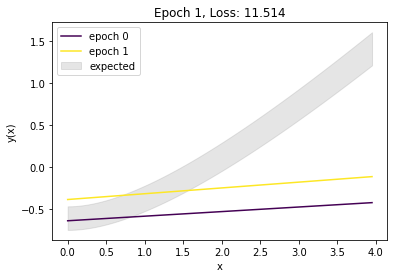

23:49:40.535 [INFO] Epoch: 2, Loss: 7.000825881958008,	W = [ 0.2951,  0.3171,  0.2728,  0.2061,  0.2915,  0.2533,  0.0318]



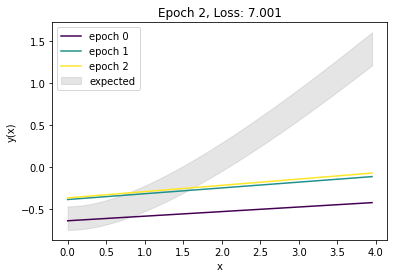

23:49:40.672 [INFO] Epoch: 3, Loss: 6.737744331359863,	W = [ 0.3050,  0.3167,  0.2698,  0.2035,  0.2880,  0.2619,  0.0322]



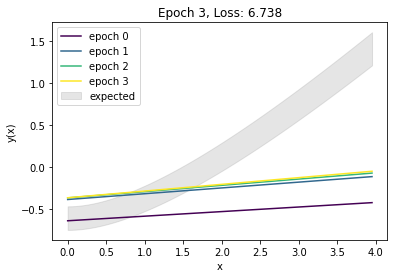

23:49:40.847 [INFO] Epoch: 4, Loss: 6.54633092880249,	W = [ 0.3144,  0.3177,  0.2669,  0.1996,  0.2861,  0.2699,  0.0312]



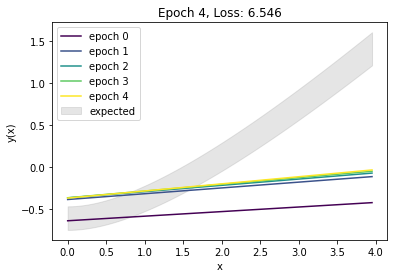

23:49:41.630 [INFO] Epoch: 5, Loss: 6.369869709014893,	W = [ 0.3234,  0.3187,  0.2641,  0.1956,  0.2844,  0.2776,  0.0301]



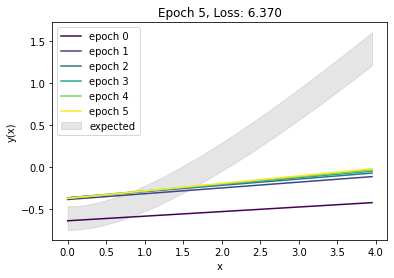

23:49:41.224 [INFO] Epoch: 6, Loss: 6.20468282699585,	W = [ 0.3322,  0.3198,  0.2613,  0.1918,  0.2828,  0.2851,  0.0290]



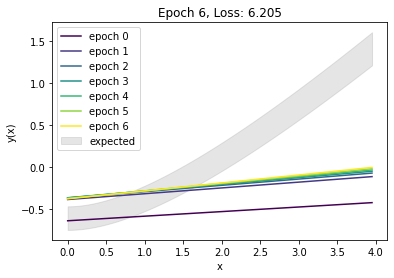

23:49:41.401 [INFO] Epoch: 7, Loss: 6.050701141357422,	W = [ 0.3406,  0.3208,  0.2587,  0.1882,  0.2811,  0.2923,  0.0280]



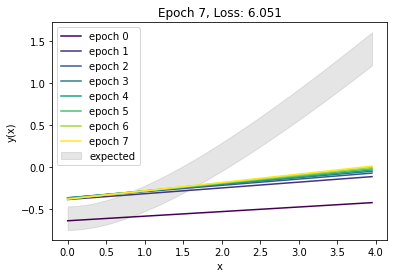

23:49:41.692 [INFO] Epoch: 8, Loss: 5.9068193435668945,	W = [ 0.3488,  0.3216,  0.2561,  0.1848,  0.2794,  0.2992,  0.0272]



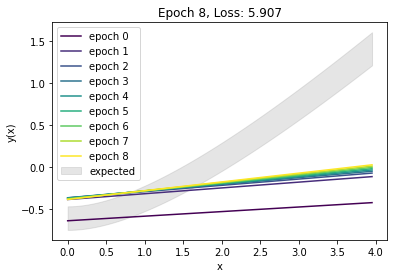

23:49:41.903 [INFO] Epoch: 9, Loss: 5.773477077484131,	W = [ 0.3565,  0.3227,  0.2537,  0.1813,  0.2780,  0.3058,  0.0261]



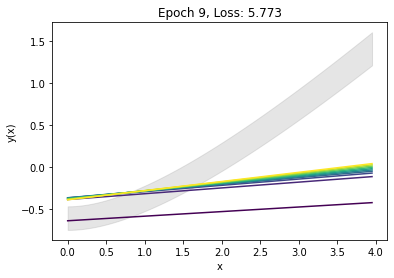

23:49:42.540 [INFO] Epoch: 10, Loss: 5.6513495445251465,	W = [ 0.3641,  0.3235,  0.2513,  0.1782,  0.2764,  0.3123,  0.0254]



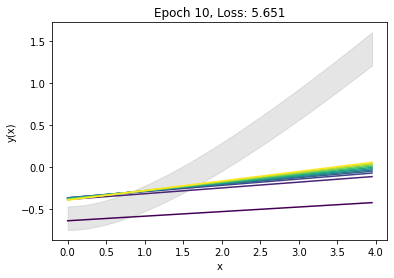

23:49:42.221 [INFO] W = [ 0.3641,  0.3235,  0.2513,  0.1782,  0.2764,  0.3123,  0.0254]
23:49:42.222 [INFO] Pruning weights...
23:49:42.297 [INFO] Constructed symbolic model
23:49:42.377 [INFO] Integrated
23:49:42.391 [INFO] Constructed JAXified model
23:49:42.419 [INFO] W₀ = [ 0.3641,  0.3235,  0.3123,  0.0254]
23:49:42.707 [INFO] Epoch: 1, Loss: 6.481998443603516,	W = [ 0.3665,  0.3470,  0.3151,  0.0018]



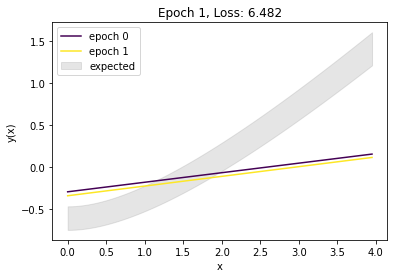

23:49:42.892 [INFO] Epoch: 2, Loss: 5.7587175369262695,	W = [ 0.3708,  0.3608,  0.3200, -0.0120]



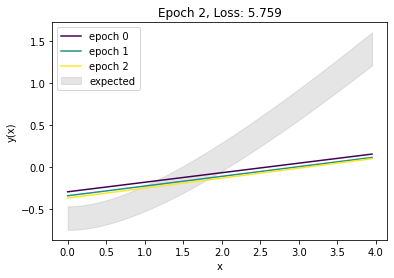

23:49:43.159 [INFO] Epoch: 3, Loss: 5.4772539138793945,	W = [ 0.3761,  0.3684,  0.3262, -0.0195]



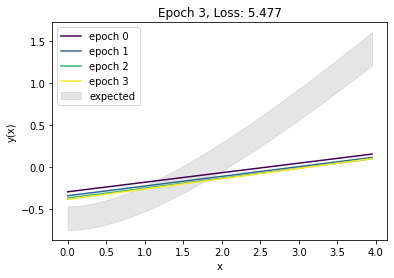

23:49:43.342 [INFO] Epoch: 4, Loss: 5.329954147338867,	W = [ 0.3818,  0.3732,  0.3328, -0.0243]



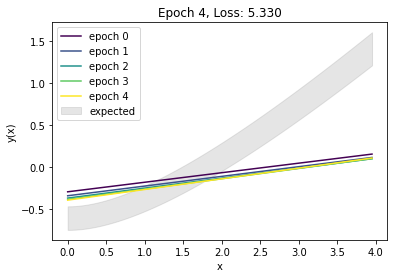

23:49:43.534 [INFO] Epoch: 5, Loss: 5.222517013549805,	W = [ 0.3876,  0.3764,  0.3394, -0.0275]



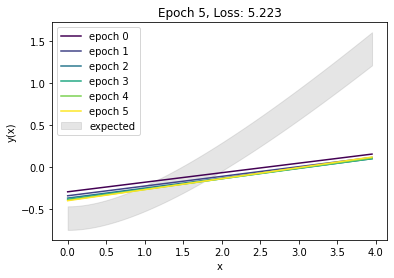

23:49:43.704 [INFO] Epoch: 6, Loss: 5.132277011871338,	W = [ 0.3932,  0.3788,  0.3458, -0.0299]



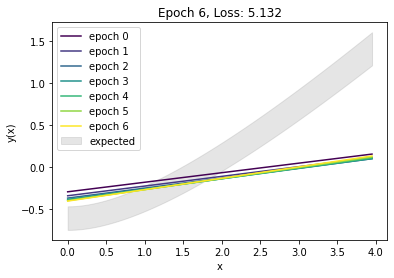

23:49:43.888 [INFO] Epoch: 7, Loss: 5.052700996398926,	W = [ 0.3987,  0.3806,  0.3520, -0.0318]



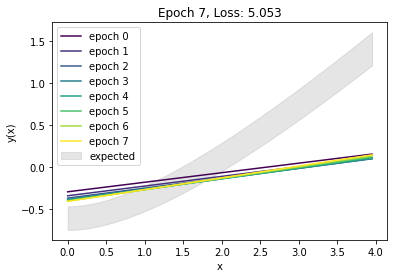

23:49:44.249 [INFO] Epoch: 8, Loss: 4.981018543243408,	W = [ 0.4039,  0.3821,  0.3580, -0.0332]



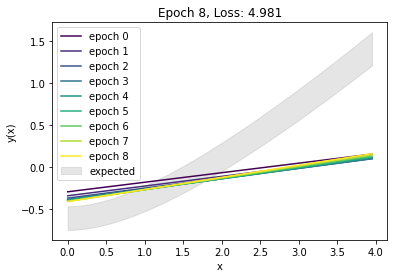

23:49:44.435 [INFO] Epoch: 9, Loss: 4.916584491729736,	W = [ 0.4089,  0.3836,  0.3635, -0.0347]



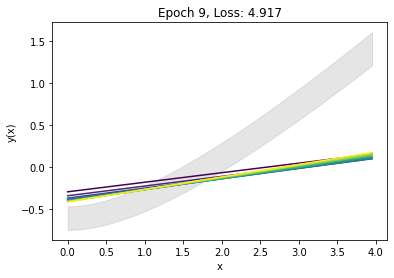

23:49:44.607 [INFO] Epoch: 10, Loss: 4.859236240386963,	W = [ 0.4137,  0.3848,  0.3689, -0.0360]



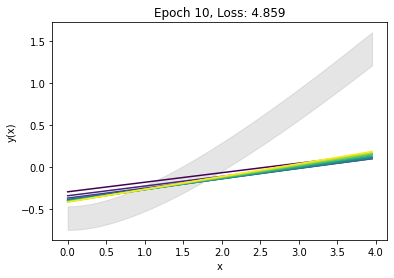

23:49:44.791 [INFO] W = [ 0.4137,  0.3848,  0.3689, -0.0360]
23:49:44.791 [INFO] Pruning weights...
23:49:44.821 [INFO] Constructed symbolic model
23:49:44.866 [INFO] Integrated
23:49:44.878 [INFO] Constructed JAXified model


Nothing more to prune!


In [9]:
key = random.PRNGKey(7)

key, subkey = random.split(key)
W = random.uniform(subkey, shape=(len(network.alphas),), minval=0, maxval=0.1)

is_final = False

while not is_final:
    plotting.funcs = []
    W, loss_history, plotting_new = train(
        network,
        dataset = [(0, -0.6081976)],
        plotting = plotting,
        key = key,
        lr = 0.001,
        lr_2 = 0.001,
        epochs = 10,
        verbose = 0,
        batch_size = 16,
        W_init = W
    )

    info('Pruning weights...')
    network.assign_weights(W)
    W, model_y, loss_and_grad, is_final = network.prune_auto()